In [58]:
import numpy as np
import seaborn as sns

from bam_poses.data.person import Person
from bam_poses.data.group import Group

In [64]:
tracks = Person.load_for_dataset(dataset="A")
group = Group(tracks)
poses, masks = group.get_splits(length=100, non_overlapping=True) # 4sec*25Hz=100 frames

100%|██████████| 18/18 [00:00<00:00, 31.60it/s]


In [9]:
poses.shape, masks.shape

((1289, 18, 100, 18, 3), (1289, 18, 100, 18, 1))

# Exploratory Data Analysis

working hypothesis: mask=0 means not present, mask=1 means present

In [31]:
n_scenes, n_persons, n_frames, n_joints, n_dim = poses.shape
all_persons = n_scenes*n_persons
print("all persons", all_persons)

all persons 23202


In [33]:
print(f"fraction of all persons that are fully visible during the whole scene {masks.reshape(-1, 100*18).min(axis=1).sum()/all_persons:.3%}")

fraction of all persons that are fully visible during the whole scene 22.132%


In [36]:
print(f"fraction of all persons that have 0 visible joints during the whole scene {1 - masks.reshape(-1, 100*18).max(axis=1).sum()/all_persons:.3%}")

fraction of all persons that have 0 visible joints during the whole scene 0.000%


In [ ]:
np.mean(masks)

0.2820197013667404

In [ ]:
print("mean mask value for the 18th joint")
np.mean(masks[:, :, :, 17, :])

1.0

histogram over the number of fully visible people per scene


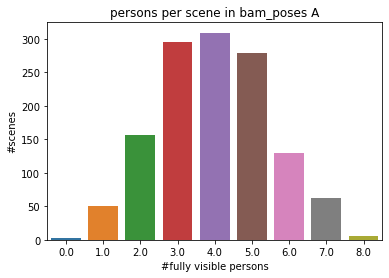

In [52]:
_ = np.unique(masks.reshape(n_scenes, n_persons, -1).min(axis=2).sum(axis=1), return_counts=True)
#print("histogram over the number of fully visible people per scene")
sns.barplot(x=_[0], y=_[1]).set(xlabel="#fully visible persons", ylabel="#scenes", title="persons per scene in bam_poses A");

In [61]:
# offline version with stats, similar to the online versio in data_bam_poses.py

def squeeze_and_remove_missing(poses, masks, print_diagnostics=True):
    """Remove all persons from scenes that are not fully visible the entire time (i.e. at least one joint mask is 0 at some point). The visible persons are grouped together and moved to the top so that a scene always consists of n visible persons followed by (18-n) nan entries.

    Parameters
    ----------
    poses : np.ndarray
        poses from bam_poses
    masks : np.ndarray
        masks from bam_poses
    print_diagnostics : bool, optional
        print stats, by default True

    Returns
    -------
    np.ndarray
        same shape as poses and np.nan for all missing persons.
    """
    n_scenes, n_persons, n_frames, n_joints, n_dim = poses.shape

    data = np.full_like(poses, np.nan) # fill all missing persons with nan
    fully_present_ctr, partial_ctr, only_one_ctr, fully_missing_ctr = 0, 0, 0, 0
    for iscene in range(n_scenes):
        
        people = []
        for iperson in range(n_persons):
            # select people that are fully present
            mean_mask = np.mean(masks[iscene, iperson, :, :, :])
            if mean_mask > 0.999:
                fully_present_ctr += 1
                people.append(poses[iscene, iperson])
            elif mean_mask < 0.001:
                fully_missing_ctr += 1
            elif mean_mask <= (1/18 + 0.001):
                only_one_ctr += 1
            else:
                partial_ctr += 1
        
        # add all fully present people
        for iperson, person in enumerate(people):
            data[iscene, iperson] = person

        # the rest of all person entries will be nan

    all_persons = n_scenes*n_persons
    if print_diagnostics:
        print(f"total persons (n_scenes*n_persons): {all_persons}")
        print(f"persons with 18 joints: {fully_present_ctr/all_persons:.2%}")
        print(f"persons with 2-17 joints: {partial_ctr/all_persons:.2%}")
        print(f"persons with 1 joint: {only_one_ctr/all_persons:.2%}")
        print(f"persons with 0 joints: {fully_missing_ctr/all_persons:.2%}")

    return data


In [60]:
data = squeeze_and_remove_missing(poses, masks)

100%|██████████| 1289/1289 [00:00<00:00, 3709.85it/s]

total persons (n_scenes*n_persons): 23202
persons with 18 joints: 22.13%
persons with 2-17 joints: 2.72%
persons with 1 joint: 75.15%
persons with 0 joints: 0.00%
